## Гаврюшенко Анастасия. Лабораторна робота 3, Вариант 3

Побудова рекомендаційної системи фильмів користувачам на основі рейтингу за допомогою методу Ймовірностної матричної факторизації. Серед перевірених К possible_k_list = [5, 10, 15, 20, 30, 40], виявилось, що К=40-найкраще

In [78]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

In [47]:
orig_data = pd.read_csv("data/user_ratedmovies-timestamps.dat", sep='\t')
data = orig_data[orig_data.columns[:-1]]

In [48]:
data.describe()

,userID,movieID,rating
count,855598.000000,855598.000000,855598.000000
mean,35190.832551,8710.179402,3.437945
std,20385.003347,14446.852908,1.002561
min,75.000000,1.000000,0.500000
25%,18161.000000,1367.000000,3.000000
50%,33866.000000,3249.000000,3.500000
75%,52004.000000,6534.000000,4.000000
max,71534.000000,65133.000000,5.000000


In [49]:
#build spread matrix
rating_matrix = data.pivot(index='userID', columns='movieID', values='rating')
n_users, n_movies = rating_matrix.shape

In [50]:
#Scaling ratings to between 0 and 1
min_rating, max_rating = data['rating'].min(), data['rating'].max()
scaled_rating_matrix = (rating_matrix - min_rating) / (max_rating - min_rating)
rating_matrix = scaled_rating_matrix

In [51]:
#replace None to -1 for easier detection
rating_matrix[rating_matrix.isnull()] = -1
rating_matrix = torch.FloatTensor(rating_matrix.values)

In [52]:
#implementing loss for our particular case
class PMFLoss(torch.nn.Module):
    def __init__(self, lam_u=0.3, lam_v=0.3):
        super().__init__()
        self.lam_u = lam_u
        self.lam_v = lam_v
    
    def forward(self, matrix, u_features, v_features):
        non_zero_mask = (matrix != -1).type(torch.FloatTensor)
        predicted = torch.sigmoid(torch.mm(u_features, v_features.t()))
        
        diff = (matrix - predicted)**2
        prediction_error = torch.sum(diff*non_zero_mask)

        u_regularization = self.lam_u * torch.sum(u_features.norm(dim=1))
        v_regularization = self.lam_v * torch.sum(v_features.norm(dim=1))
        
        return prediction_error + u_regularization + v_regularization

In [53]:
criterion = PMFLoss()
loss = criterion(rating_matrix, user_features, movie_features)

In [54]:
def init_feature_matrices(n_users, n_movies, latent_vectors):
    user_features = torch.randn(n_users, latent_vectors, requires_grad=True)
    user_features.data.mul_(0.01)
    movie_features = torch.randn(n_movies, latent_vectors, requires_grad=True)
    movie_features.data.mul_(0.01)
    return (user_features, movie_features)

In [72]:
def training_loop(latent_vectors=20, n_epoch=201, lr=0.01, check_every=50):
    user_features, movie_features = init_feature_matrices(n_users, n_movies, latent_vectors)
    pmferror = PMFLoss(lam_u=0.05, lam_v=0.05)
    optimizer = torch.optim.Adam([user_features, movie_features], lr=lr)
    for step, epoch in enumerate(range(n_epoch)):
        optimizer.zero_grad()
        loss = pmferror(rating_matrix, user_features, movie_features)
        loss.backward()
        optimizer.step()
        if step % check_every == 0:
            print(f"Step {step}, {loss:.3f}")
    return user_features, movie_features

In [67]:
def check_prediction(take_first = 100):
    user_idx = take_first
    user_ratings = rating_matrix[user_idx, :]
    true_ratings = user_ratings != -1
    predictions = torch.sigmoid(torch.mm(user_features[user_idx, :].view(1, -1), movie_features.t()))
    predicted_ratings = (predictions.squeeze()[true_ratings]*(max_rating - min_rating) + min_rating).round()
    actual_ratings = (user_ratings[true_ratings]*(max_rating - min_rating) + min_rating).round()
    accuracy = float(sum(predicted_ratings == actual_ratings)) / len(actual_ratings)
    #print("Predictions: \n", predicted_ratings)
    #print("Truth: \n", actual_ratings)
    print("accuracy ", accuracy)
    return accuracy

In [74]:
possible_k_list = [5, 10, 15, 20, 30, 40]
accuracy = []
for latent_vectors in possible_k_list:
    user_features, movie_features = init_feature_matrices(n_users, n_movies, latent_vectors)
    user_features, movie_features = training_loop(latent_vectors)
    print('FOR ', latent_vectors, end=' : ')
    accuracy.append(check_prediction())
    print('\n')

Step 0, 62478.488
Step 50, 29480.344
Step 100, 25254.895
Step 150, 24090.549
Step 200, 23354.082
FOR  5 : accuracy  0.550979068197164


Step 0, 62484.230
Step 50, 27151.756
Step 100, 23887.670
Step 150, 21668.842
Step 200, 20438.562
FOR  10 : accuracy  0.5725860904794058


Step 0, 62488.531
Step 50, 25932.588
Step 100, 22415.920
Step 150, 19640.803
Step 200, 18366.389
FOR  15 : accuracy  0.6049966239027684


Step 0, 62492.324
Step 50, 25816.537
Step 100, 21239.395
Step 150, 18168.338
Step 200, 16868.236
FOR  20 : accuracy  0.6225523295070898


Step 0, 62498.367
Step 50, 24289.383
Step 100, 18770.314
Step 150, 15594.516
Step 200, 14339.578
FOR  30 : accuracy  0.636731937879811


Step 0, 62503.379
Step 50, 22489.348
Step 100, 16563.688
Step 150, 13628.606
Step 200, 12415.232
FOR  40 : accuracy  0.6704929101958136




(2113, 40)
(10109, 40)


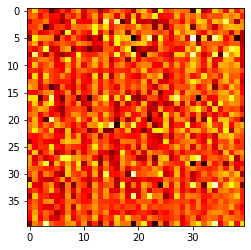

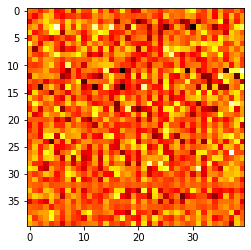

In [91]:
user_features_np = user_features.detach().numpy()
movie_features_np = movie_features.detach().numpy()
print(user_features_np.shape)
print(movie_features_np.shape)
uf_shape = user_features_np.shape
mf_shape = movie_features_np.shape
plt.imshow(user_features_np[:uf_shape[1],], cmap='hot', interpolation='nearest')
plt.show()
plt.imshow(movie_features_np[:mf_shape[1],], cmap='hot', interpolation='nearest')
plt.show()

In [76]:
accuracy

[0.550979068197164,
 0.5725860904794058,
 0.6049966239027684,
 0.6225523295070898,
 0.636731937879811,
 0.6704929101958136]